# Tutorial 4: Bayesian Linear Regression and Gaussian Processes

Welcome to the fourth tutorial of the course 'Machine learning for Precision Medicine'.
 
In the last exercise we predicted the insurance cost of a customer, based on 6 health variables using basis functions and kernelized regression. Now we want to add uncertainty estimates to our predictions (i.e. standard deviations of the expected cost). 

As we will see this requires only minimal adjustments to our original kernelized Ridge regression model. For this reason this week's tutorial will be a bit shorter than usual.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# we will make use of the sklearn.metrics.pairwise_kernels function:
from sklearn.metrics.pairwise import pairwise_kernels

We will load the data and perform the same pre-processing as before, i.e. one-hot encoding and standardization.

In [2]:
# load the data, and check out the first couple of rows
data = pd.read_csv('./insurance.csv', header=0)
data_orig = data

In [3]:
# 1-hot encoding for the categorical variables
data = pd.get_dummies(data, columns=['region','smoker','sex'])
print('old variables: {}'.format(list(data_orig.columns)))
# we get rid of the redundant columns:
data.drop(labels=['smoker_no','sex_male','region_northeast'], axis=1, inplace=True)
print('new variables: {}'.format(list(data.columns)))

old variables: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
new variables: ['age', 'bmi', 'children', 'charges', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_yes', 'sex_female']


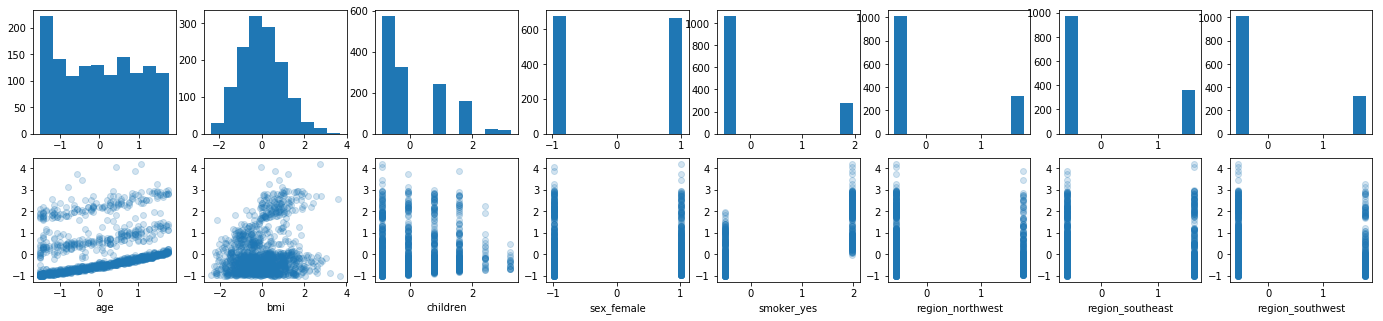

In [4]:
# Set dependent and independent variables 
dep_var = ['charges']
indep_var = ['age','bmi','children','sex_female','smoker_yes','region_northwest','region_southeast','region_southwest']

# standardize the data 
def zscore(x):
    return np.array((x - np.mean(x)) / (np.std(x)))

data = data.apply(zscore)

# Plot the distributions and see how the data is associated with cost (charges)
fig, ax = plt.subplots(2,len(indep_var),figsize=(24, 5))
for i, v in enumerate(indep_var):
    ax[0,i].hist(data[v])
    ax[0,i].set_xlabel('')
for i, v in enumerate(indep_var):
    ax[1,i].scatter(data[v],data[dep_var].values, alpha=0.2)
    ax[1,i].set_xlabel(v)

In [5]:
# define the training set
X = data[indep_var].values
y = data[dep_var].values

# split in to train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

## Introduction

In our previous exercise on kernelized linear regression, we made use of the following formula to estimate the dual variable $\mathbf a$ (our regression parameters), which, taking into account the L2 regularization penalty weighted by $\lambda$, minimizes the mean squared error of our kernelized regression: 

 $$ \mathbf a = (\mathbf K + \lambda \mathbf I)^{-1}\mathbf y$$

Where $\mathbf{K}$ is the kernel matrix of our training observations $\mathbf{X}$.

We obtained this result by setting the gradient of the objective function ($E_2$) below to zero with respect to $\mathbf{a}$.

$$ E_2(\mathbf{a}) = 0.5*\mathbf{a}^T \mathbf{K}\mathbf{K} \mathbf{a} - \mathbf{a}^T\mathbf{K}\mathbf{y} + 0.5 * \mathbf{y}^T\mathbf{y} + 0.5*\lambda \mathbf{a}^T\mathbf{K}\mathbf{a}^T$$

where $\mathbf{y}$ is our response variable (see lecture slide 15, lecture 4 - *Basis Functions and Kernels*). The additive term on the right denotes the regularization penalty, while the others relate to the mean squared error. We then used cross-validation to find an optimal value for $\lambda$.


In the lecture *Bayesian Linear Regression and Gaussian Pocesses* we discussed the Bayesian interpretation of linear regression. In a Bayesian setting, we no longer predict simple point-estimates for our outcome variables ($\mathbf{y}^*$), but rather our predictions themselves become distributions, conditioned on the training data ($\mathbf{X}, \mathbf{y}$), the new observations ($\mathbf{X}^*$), our choice of kernel $\theta_K$ (implying a choice of basis function) and our prior (which we will parameterize by $\sigma^2$).

The uncertainty in our predictions then factors into two parts. One part comes from noise, which is inherent in the data (and is irreducible!). The second part arises from uncertainty in our model parameters. This second part is due to only ever observing a finite amount of training data and decreases as the amount of training data increases.

We then found that this predicitve distribution, which we will call $\mathbf{f}^*$ is itself a Gaussian distribution, if our model weights and the noise follow Gaussian distributions and the predictions are linear kombinations of (the transformed) input variables. Is is what is referred to as a Gaussian process.

In fact, we found out that adding an L2-penalty to our model weights is equivalent to placing a prior over our model weights assuming mean $\mu = 0$ and variance parameterized by $\lambda$.


Finally, because the predictive distribution $\mathbf{f}^*$ is a multivariate Gaussian, it can be described by a vector of mean values $\mu^*$ and a covariance matrix ${\Sigma^*}$. I.e:

$$p(\mathbf{f}^{*}|\mathbf{X},\mathbf{y},\mathbf{X}^*,\theta_K,\sigma^2)=\mathcal{N}(\mu^*, \Sigma^*)$$

For reference, please consider lecture slide 34.

Now we want to calculate the mean and covariance matrix of our predictive distribution by completing the square (tip: look up the mathematical term "completing the square" if you do not know what this means). The mean value of our predictive distribution is based on the Kernel matrix ($\mathbf{K_{X^*,X}}$) between our new observations ($\mathbf{X}^*$) and our training observations ($\mathbf{X}$), $\mathbf{y}$ and ${\sigma^2}$:

$$\mu^* = \mathbf{K_{X^*,X}}[\mathbf{K_{X,X}}+\sigma^2 \mathbf I]^{-1} \mathbf y$$

**Question 1**:

See how the formula above relates to how we made predictions with our kernelized ridge regression model. What is the interpretation of $\sigma^2$?

The covariance matrix ${\Sigma^*}$ is calculated the following way:

$$\Sigma^* =  \mathbf{K_{X^*,X^*}} - \mathbf{K_{X^*,X}}[\mathbf{K_{X,X}}+\sigma^2 \mathbf I]^{-1}\; \mathbf{K_{X,X^*}}$$

Using the two formulae above we will calculate the mean and covariance matrix of our predictive distribution. We will use the value for $\lambda$ which we found in the last exercise as our $\sigma^2$ for the rbf-kernel.

## Task 1: ##  
Complete the function `predictive_Gauss` below. It takes the following parameters:

- `X`: training data X (matrix, `np.ndarray`)
- `y`: training data y (vector, `np.ndarray`)
- `X_star`: new observations X (matrix, `np.ndarray`)
- `metric`: metric passed to the `pairwise_kernels()` function (see imports in the beginning of the exercise, `str`)
- `sigma_sq`: sigma-squared parameter (`float`)

It returns `mu_star` and `sigma_star` defined above.

In [6]:
def predictive_Gauss(X,y,X_star, metric, sigma_sq):
    
    # your_code
    K=pairwise_kernels(X,metric=metric)
    K_xstar=pairwise_kernels(X_star,X,metric=metric)
    sigmaEye=sigma_sq*np.eye(K.shape[0])
    invM=np.linalg.inv(K+sigmaEye)
    mu_star=K_xstar.dot(invM).dot(y)
    K_star=pairwise_kernels(X_star,metric=metric)
    K_starX=pairwise_kernels(X,X_star,metric=metric)
    sigma_star=K_star-(K_xstar.dot(invM).dot(K_starX))
    print("mu :",mu_star.shape," sigma :",sigma_star.shape )
    return mu_star, sigma_star

**Question: **  
What is the shape of $\Sigma^*$ if you predict for $N$ new observations? How can you retrieve the variance of a single prediction $y^*_i$ from $\Sigma^*$?

In [7]:
best_lambd = 0.15199110829529347
mu_star, sigma_star = predictive_Gauss(X_train,y_train,X_test, 'rbf', best_lambd)

print('mu_star[10]: {}\nsigma_star[10,10]: {}'.format(mu_star[10],sigma_star[10,10]))
print('No expected output this time! ;)')

mu : (268, 1)  sigma : (268, 268)
mu_star[10]: [-0.22476383]
sigma_star[10,10]: 0.015820417904561346
No expected output this time! ;)


## Task 2: ## 
Retrieve the standard deviation for each all predictions $\mathbf{y}^*$ (`sigma_star`):

In [8]:
standard_deviations = np.std(sigma_star)#your_code

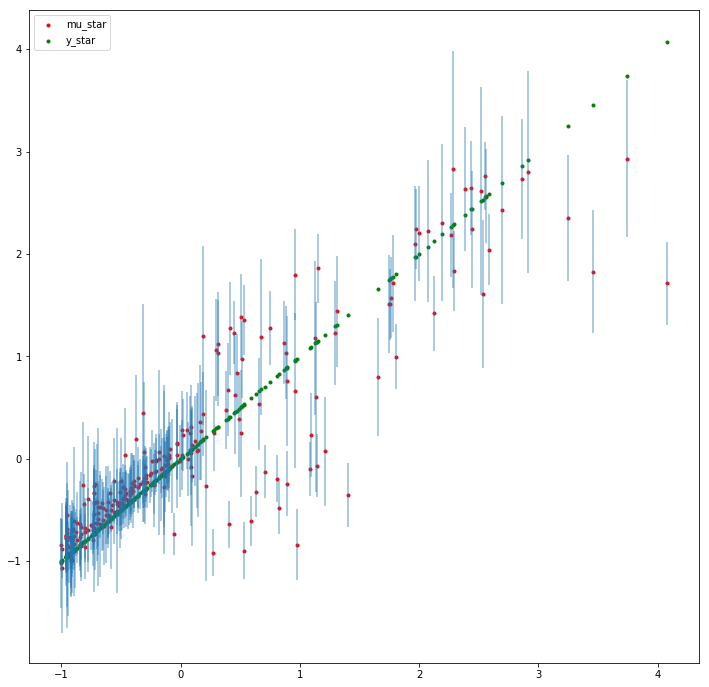

In [9]:
# we plot our predictions with error-bars denoting +-2*(standard deviation) 

plt.figure(figsize=(12, 12))

plt.errorbar(y_test, mu_star, 2*np.sqrt(np.diagonal(sigma_star)), fmt='none', alpha=0.5)
plt.scatter(y_test, mu_star, s=9, c='r', label='mu_star')
plt.scatter(y_test, y_test, s=9, c='g', label='y_star')
plt.legend()

# you should now see a scatter-plot with red points, blue-error bars and green points on the diagonal:

Congratulations, you made it through the fourth tutorial of this course!  

# Submitting your assignment

Please rename your notebook under your full name and **submit it on the moodle platform**.

Please rename the file to 4_BayesReg_<GROUP\>.ipynb and replace <GROUP\> with your group-name.

As this is also the first time for us preparing this tutorial, you are welcome to give us feedback to help us improve this tutorial.  

Thank you!  

Jana & Remo